# Predicting Heart Disease Based On Medical Characteristics

Group 157: Evan Armstrong, Seyed Mehrbod Naseri, Ram Jayakumar, Zimo Zhang

# Introduction

As the leading cause of death globally, heart disease is a common and often-lethal condition that affects nearly all humans (Ritchie et al., 2018). Any methods that can accurately predict heart disease, such as one based on relatively easy-to-observe qualities, would allow for quicker action from doctors and better patient outcomes. Thus, this report asks the following question: is it possible to predict whether a patient has heart disease based on medical characteristics? We will also explore the secondary question: do regions share the same predictors for heart disease? Our model will use the publicly-available heart disease dataset donated by the Hungarian Institute of Cardiology, the University Hospitals of Zurich and Basel, the V. A. Medical Center of Long Beach, and the Cleveland Clinic Foundation was used (Janosi et al., 1989). Each row in this dataset represents a patient, and the columns store physical, health-related information about each patient — such as their age, sex, type of chest pain, and resting blood pressure. There are 14 variables in total. We decided to use the KNN classification algorithm with forward selection to predict the "num" column, which is either “true” or “false” if an individual has heart disease. We decided to use KNN classification as we are classifying an observation, and not estimating a continuous value. The dataset contains four databases, each with around 100 to 300 patients, donated by institutions in Switzerland, Hungary, and two locations in America. We will train and test our model on data from all of the databases, and add a new variable: "region". This brings the total number of columns in our dataset to 15.

## Methods and Results

Here, we will build 5 models: a model for every database and another model for all the databases. We use the KNN (K-nearest neighbours) classification algorithm with forward selection to pick the best predictors and cross-validation to pick the best K parameter. This is summarized in a series of confusion matrices.
The 10 variables we are considering for our predictive model, and our reasons for including them, are:

1. **Age** (column name: *"age"*)<br>
    With age comes the onset of factors such as frailty, obesity, and diabetes, which increase the risk of heart disease (Rodgers et al., 2019).

1. **Sex** (column name: *"sex"*)<br>
    Hormonal decline with age is another factor to increases the risk of heart disease, and is more drastic in females with the onset of menopause (Rodgers et al., 2019).
    
1. **Chest Pain** (column name: *"cp"*) <br>
    Angina is the term for chest discomfort/pain, and is caused from the heart not getting enough oxygen-rich blood, which is a symptom of heart disease (Rawat, 2021).
    
1. **Resting Blood Pressure** (column name: *"restbps"*) <br>
    Having a high resting blood pressure means your heart is under more strain than an average person, and can lead to heart disease (NHS, 2020).
    
1. **Serum Cholesterol** (column name: *"chol"*)<br>
    Abnormally high levels of low-desnity lipoprotein cholesterol can narrow arteries and contribute to heart issues (NHS, 2020). 

1. **Resting ECG** (column name: *"restecg"*) <br>
    Resting electrocardiography can detect abnormalities in an individual that are related to heart disease (Kaolawanich et al., 2021).
    
1. **Max Heart Rate Achieved/Thalach** (column name: *"thalach"*) <br>
    Increases in heart rate has been associated with risk of cardiac death; 10 more beats per minute can yield a 20% higher risk of cardiac death (Perret-Guillaume et al., 2009).
    
1. **Exercise Induced Angina** (column name: *"exang"*) <br>
    Exercise-induced angia is chest pain that a patient experiences while exercising, and has been linked to heart disease in the past (Chen et al., 2011). 
    
1. **ST depression induced by exercise** (column name: *"oldpeak"*) <br>
    Studies have found that exercise induced ST segment depression, which is what this variable represents, are associated with heart disease due to an imbalance in oxygen demand (Watanabe et al., 2000). 

We attempt to keep the number of predictors considered low as too many predictors can interfere with the accuracy of forward selection (Campbell et al., 2022, section 6.8.2, para. 8).

This code should take roughly 1200 seconds to run.

## Preliminary Exploratory Data Analysis

### Imports

We first must load the required libraries that allow us to manipulate and present the data.

In [1]:
# load libraries
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6) # change how tables are displayed
set.seed(1048596) # arbitrary seed number picked as an obscure reference to Steins;Gate.

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Reading and tidying the data: to start with, a function

We create a function which performs repetitive tasks of tidying each freshly-loaded data frame. including: removing observations with missing data, selecting the variables we chose as predictors, creating a "region" column, and changing the type of some variables to reflect the data better.

In [2]:
# Function to tidy up each of the separate datasets
# Discovery: in the non-cleveland sets, many of the more obscure columns have missing values in some rows. If you filter out all the rows that don't have missing values anywhere you sometimes end up with none from that set.

tidy_heart_data <- function(df, region="") {
    colnames(df) <- column_names
    df <- mutate(df, region=region)
    # Change all heart disease numbers to easily-interpreted true/false values
    for(i in 1:length(df$num)) {
       tf <- NULL
       if (df$num[i] != 0) {
           tf <- "true"
       } else {
           tf <- "false"
           }
           
       df$num[i] <- tf
       }

    if (region != "") {
        df <- mutate(df, region=as.factor(region))
        }
    df <- df |> select(num,
                         age, #
                         region,
                         cp, #
                         sex,#
                         thalach, #
                         trestbps, #
                         chol, #
                         fbs, #
                         restecg, #
                         exang, #
                         oldpeak, #
                         
                        ) |> # Filter out NA values, and values that do not make physical sense
                          filter(cp!="?", 
                                 sex!="?",
                                 thalach!="?",
                                 trestbps!="?",
                                 trestbps!="0", # a blood pressure of 0 is impossible
                                 chol!="?",
                                 fbs!="?",
                                 restecg!="?",
                                 exang!="?",
                                 oldpeak!="?",)|>
                          mutate(region=as.factor(region),
                                 sex=as.numeric(sex),
                                 cp=as.numeric(cp),
                                 thalach=as.numeric(thalach),
                                 trestbps=as.numeric(trestbps),
                                 chol=as.numeric(chol),
                                 fbs=as.numeric(fbs),
                                 restecg=as.numeric(restecg),
                                 exang=as.numeric(exang),
                                 oldpeak=as.numeric(oldpeak),
                                 # slope=as.numeric(slope),
                                 # ca=as.numeric(ca),
                                 # thal=as.numeric(thal),
                                 num = as.factor(num))
    # print(df |> group_by(cp,num) |> summarize(n())) # debug
    return(df)
    }

column_names <-c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")

### Reading and tidying the data: Calling the function
The cells below each call the above function with one of the databases. 

In [3]:
# Load and tidy Cleveland dataset
cleveland_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                         col_name = FALSE)
cleveland_data <- tidy_heart_data(cleveland_data,"C")

print("Table 1: Cleveland dataset (tidied and filtered)")
cleveland_data               
# Table 1

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: Cleveland dataset (tidied and filtered)"


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,63,C,1,1,150,145,233,1,2,0,2.3
true,67,C,4,1,108,160,286,0,2,1,1.5
true,67,C,4,1,129,120,229,0,2,1,2.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
true,57,C,4,1,115,130,131,0,0,1,1.2
true,57,C,2,0,174,130,236,0,2,0,0.0
false,38,C,3,1,173,138,175,0,0,0,0.0


In [4]:
# Load and tidy Hungary dataset
hungarian_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",
                          col_name = FALSE)
hungarian_data <- tidy_heart_data(hungarian_data,"H")

print("Table 2: Hungarian dataset (tidied and filtered)")
hungarian_data
# Table 2

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 2: Hungarian dataset (tidied and filtered)"


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,28,H,2,1,185,130,132,0,2,0,0
false,29,H,2,1,160,120,243,0,0,0,0
false,30,H,1,0,170,170,237,0,1,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
true,56,H,4,1,150,155,342,1,0,1,3
true,58,H,2,0,110,180,393,0,0,1,1
true,65,H,4,1,115,130,275,0,1,1,1


In [5]:
# Load and tidy Switzerland dataset
switzerland_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
                            col_name = FALSE)
switzerland_data <- tidy_heart_data(switzerland_data,"S")
print("Table 3: Switzerland dataset (tidied and filtered)")

switzerland_data
# Table 3

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 3: Switzerland dataset (tidied and filtered)"


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
true,38,S,4,0,156,110,0,0,0,0,0
true,38,S,3,1,128,115,0,0,0,1,0
true,42,S,4,1,99,145,0,0,0,1,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
true,70,S,4,1,92,115,0,0,1,1,0
true,70,S,4,1,157,140,0,1,0,1,2
true,73,S,3,0,121,160,0,0,1,0,0


In [6]:
# Load and tidy VA dataset

va_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",
                   col_name = FALSE)
va_data <- tidy_heart_data(va_data,"VA")
print("Table 4: VA Long Beach dataset (tidied and filtered)")
va_data
# Table 4

Rows: 200 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X7, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 4: VA Long Beach dataset (tidied and filtered)"


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
true,63,VA,4,1,112,140,260,0,1,1,3.0
false,44,VA,4,1,127,130,209,0,1,0,0.0
true,60,VA,4,1,140,132,218,0,1,1,1.5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
true,54,VA,4,0,154,127,333,1,1,0,0
true,55,VA,4,1,100,122,223,1,1,0,0
true,62,VA,2,1,93,120,254,0,2,1,0


#### Creating the combined dataset

In this cell we combine all the data from earlier into a single dataset. This allows us to analyze the accuracy of KNN on each region separately, and then each region together, to see which is more accurate. Essentially, it also allows for more exploration of this dataset during our analysis. 

In [7]:
# Combine data from all regions

all_data <-rbind(cleveland_data,hungarian_data,switzerland_data,va_data)

print("Table 5: Combination of all datasets")
all_data
# Table 5

[1] "Table 5: Combination of all datasets"


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,63,C,1,1,150,145,233,1,2,0,2.3
true,67,C,4,1,108,160,286,0,2,1,1.5
true,67,C,4,1,129,120,229,0,2,1,2.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
true,54,VA,4,0,154,127,333,1,1,0,0
true,55,VA,4,1,100,122,223,1,1,0,0
true,62,VA,2,1,93,120,254,0,2,1,0


### Summary of dataset, pre-analysis

Our combined data set has 739 observations, a reasonable amount to form our model from. Note that after tidying the Switzerland data set, we were left with 46 observations, which is significantly less than the recordings from other regions. This impacts our model for Switzerland. Now we visualize this data to see if we gain information before our data analysis.

### Visualization, pre-analysis

#### Bar plot
Before performing the analysis itself, we visualize some of the data that we loaded. 

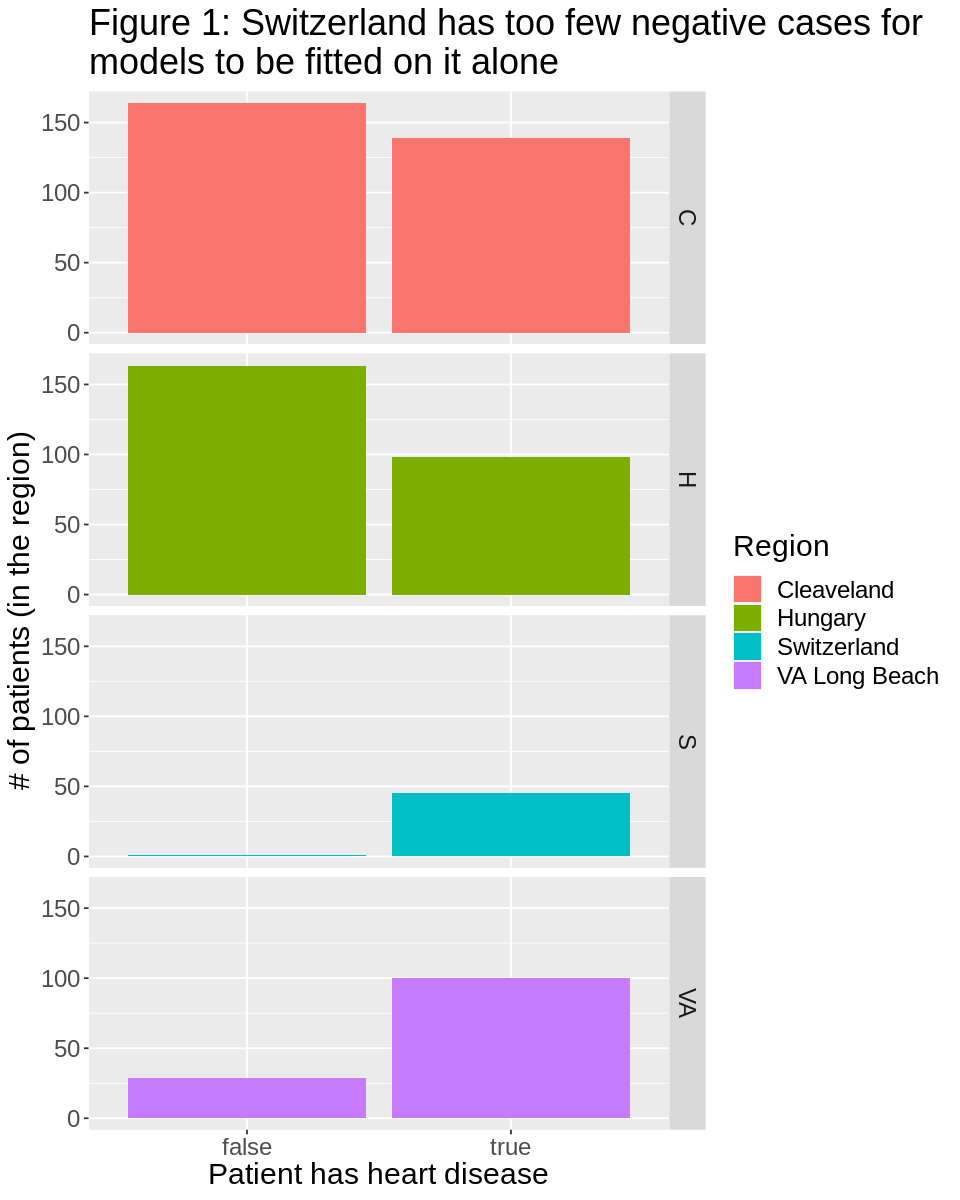

In [8]:
# Visualize distribution of positive and negative cases by region

# increase plot size
options(repr.plot.width=8, repr.plot.height=10)

# Figure 1

# print("Figure 1: VA Long Beach dataset (tidied and filtered)")
ggplot(all_data, aes(x = num, fill = region)) +
    geom_bar() +
    facet_grid(rows = vars(region)) +
    labs(x = "Patient has heart disease", y = "# of patients (in the region)", fill = "Region", title = "Figure 1: Switzerland has too few negative cases for \nmodels to be fitted on it alone") +
    scale_fill_discrete(labels = c("Cleaveland", "Hungary", "Switzerland", "VA Long Beach")) +
    theme(text = element_text(size = 18))


Figure 1 gives us a better idea of which variable will dominate the knn algorithm for each region. This visualization also reveals that we cannot make a separate model for Switzerland alone: it has just one negative case, so when split into training and testing data, one of the sets will lack any negative cases. Therefore, we will not build a separate model for Switzerland in this project.

#### Scatter plot
Figure 1 gives us a better idea of which variable will dominate the KNN algorithm for each region. This visualization reveals that we cannot make a separate model for Switzerland: it has just one negative case, so when split into training and testing data, one of the sets will lack any negative cases. Therefore, we will not build a separate model for Switzerland.

We plot chest pain versus thalach, and colour points based on the presence of heart disease, to see if there is a correlation between these predictors and the target. People with chest pain type 4 (asymptomatic, i.e., they have no chest pain) appear to be most at risk of having heart disease. One explanation for this correlation could be that people who have symptoms sufficient to warrant a medical examination and get placed on this dataset, but who lack chest pain, are at significant risk. 

This graph answers a tertiary exploratory question, "Is chest pain correlated with heart disease?" We will use a simplified version of our model to answer the predictive version of this question. This links our models' predictions with observed correlations and therefore grounds them in reality.


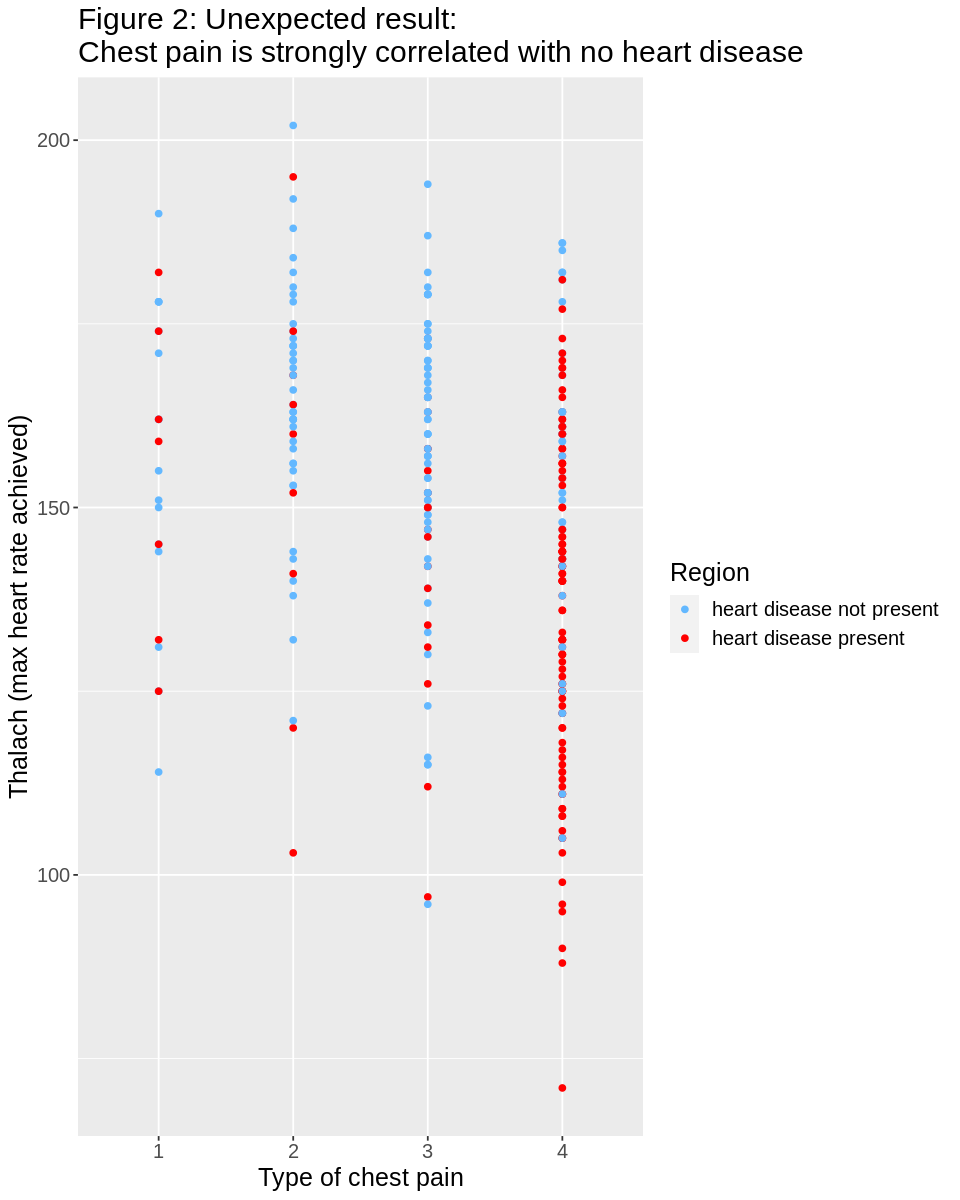

In [9]:
# Graph chest pain vs thalach colored by heart disease
# Figure 2
ggplot(cleveland_data, aes(x = factor(cp), y = thalach, color = num)) +
    geom_point() +
    labs(x = "Type of chest pain",
         y = "Thalach (max heart rate achieved)", 
         color = "Region", 
         title = "Figure 2: Unexpected result:\nChest pain is strongly correlated with no heart disease") +
    scale_color_manual(labels = c("true"="heart disease present", "false"="heart disease not present"),
                       values = c("steelblue1", "red1")) +
    # scale_x_discrete(breaks=c("1","2","3","4"),
    #     labels=c("Angina", "Atypical Angina", "Non-Angial", "Asymptomatic"))+
    theme(text = element_text(size = 15))

## Data Analysis

We visualized the dataset and now we know that our Switzerland dataset can't be used to create a model, and that patients experiencing no chest pain are much more likely to have no heart disease, based our visualizations. After some domain research, we found that this information is corroborated by how the majority of chest pains in patients are actually not cardiovascular related, and hence isn't indicative of a heart disease (Frieling, 2018). Now we perform our data analysis.

### Splitting the data into training and testing sets

In this cell we split each of our regional datasets (and our combined dataset) into  training and testing sets: given the somewhat limited size of our datasets, we prioritized model accuracy over generating a more precise estimation of this model accuracy. The ratio is 75% to the training set, 25% to the testing set. The "num" column is stratified so that positive and negative cases are evenly distributed.

In [10]:
#split all the datasets into training and testing sets

cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

hungarian_split <- initial_split(hungarian_data, prop = 0.75, strata = num)
hungarian_train <- training(hungarian_split)
hungarian_test <- testing(hungarian_split)

switzerland_split <- initial_split(switzerland_data, prop = 0.75, strata = num)
switzerland_train <- training(switzerland_split)
switzerland_test <- testing(switzerland_split)

va_split <- initial_split(va_data, prop = 0.75, strata = num)
va_train <- training(va_split)
va_test <- testing(va_split)

all_split <- initial_split(all_data, prop = 0.75, strata = num)
all_train <- training(all_split)
all_test <- testing(all_split)

print("Table 6: Training set for all regions combined")
all_train # Table 6

[1] "Table 6: Training set for all regions combined"


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,63,C,1,1,150,145,233,1,2,0,2.3
false,37,C,3,1,187,130,250,0,0,0,3.5
false,41,C,2,0,172,130,204,0,2,0,1.4
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
true,54,VA,4,0,154,127,333,1,1,0,0
true,55,VA,4,1,100,122,223,1,1,0,0
true,62,VA,2,1,93,120,254,0,2,1,0


### Forward Selection: finding the best predictors
We will now write a function which performs forward selection on a training set (provided as an argument). This function then returns a tibble which lists the accuracy that results from using different combinations and numbers of predictors with the given dataframe. This table also includes the best value of K for each model. Forward selection works thusly:

Starting with no predictors "used"...
1. try adding each of the unused predictors to the model formed by the current "used" predictors in turn; evaluate the accuracy of the resulting model
2. Whichever resulting model was the most accurate becomes the new model, and the new predictor added to it is removed from the "unused" predictors
3. The process repeats until no predictors remain

A human can then choose the model with the best combination of accuracy and simplicity*.

\**In the case of this project, because we do not start off with too many predictors, we use code to automatically pick the most accurate set of predictors and use it in later steps.*

In [11]:
# Define a function to select best parameters for a given set of training data
# Doing this with a function makes performing forward selection on all four sets of training data much easier

# The following code was adapted for this project from Chapter 6 of "Data Science: A First Introduction" by Tiffany Timbers, Trevor Campbell, and Melissa Lee.

find_predictors <- function(df) {
    
    # avoid mutating the function argument
    dataset <- df
    
    # select all numeric predictors
    names <- colnames(dataset |> select(-num,-region))

    # create an empty tibble to store the results
    accuracies <- tibble(size = integer(), 
                         model_string = character(), 
                         accuracy = numeric(),
                         k = numeric())

    # create a model specification
    knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                                 neighbors = tune()) |>
         set_engine("kknn") |>
         set_mode("classification")

    # create a 5-fold cross-validation object
    heart_vfold <- vfold_cv(dataset, v = 5, strata = num)

    # store the total number of predictors
    n_total <- length(names)

    # stores selected predictors
    selected <- c()

    # for every size from 1 to the total number of predictors
    for (i in 1:n_total) {
        # for every predictor still not added yet
        accs <- list()
        models <- list()
        ks <- list()
        for (j in 1:length(names)) {
            # create a model string for this combination of predictors
            preds_new <- c(selected, names[[j]])
            model_string <- paste("num", "~", paste(preds_new, collapse="+"))

            # create a recipe from the model string
            heart_recipe <- recipe(as.formula(model_string), 
                                    data = dataset) |>
                              step_scale(all_predictors()) |>
                              step_center(all_predictors())

            # tune the KNN classifier with these predictors, 
            # and collect the accuracy, K for the best model
            acc <- workflow() |>
              add_recipe(heart_recipe) |>
              add_model(knn_spec) |>
              tune_grid(resamples = heart_vfold, grid = 10) |>
              collect_metrics() |>
              filter(.metric == "accuracy") 
            
            # extract the best value of K for use later when building the actual model
            best_k <- acc |> slice_max(order_by = mean, n = 1, with_ties = FALSE) |> select(neighbors) |> pull()
            
            
            # Extract the accuracy for the best model
            acc <- acc |> slice_max(order_by = mean, n = 1, with_ties = FALSE) |> select(mean) |> pull() 
            
            # add this result to the dataframe
            accs[[j]] <- acc
            models[[j]] <- model_string
            ks[[j]] <- best_k
        }
        jstar <- which.max(unlist(accs))
        accuracies <- accuracies |> 
          add_row(size = i, 
                  model_string = models[[jstar]], 
                  accuracy = accs[[jstar]],
                  k = ks[[jstar]])
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
    }

    accuracies <- mutate(accuracies, percent_accuracy = accuracy*100)
    accuracies |> select(model_string, percent_accuracy, k) |> slice_max(order_by = percent_accuracy, with_ties = FALSE, n = 1)

    return(accuracies)

}
    




### Applying the function to calculate the best predictor sets
In the cell below we calculate the best set of predictors for each dataset, using the function we wrote above. The highest-accuracy set of predictors for each dataset is printed out.

In [12]:
# Run forward selection (using the function above) on each dataset we are considering (everything excluding Switzerland)
# This will take a LONG time to run. Possibly 16 minutes.

set.seed(0337187)

all_accuracy <- find_predictors(all_train)

print("25% done...") # The waiting becomes unbearable if you don't know you're making progress

cleveland_accuracy <- find_predictors(cleveland_train)

print("50% done...")

hungarian_accuracy <- find_predictors(hungarian_train)

print("75% done...") # "Are we there yet?"

va_accuracy <- find_predictors(va_train)

print("100% done! Finally!")

[1] "25% done..."
[1] "50% done..."
[1] "75% done..."
[1] "100% done! Finally!"


We display the highest achieved accuracy values for each model, as well as the model strings that produced this accuracy, in Table 7.

In [13]:
# Produce a table with the best models and their model strings
all_accuracy_for_comb <- all_accuracy |> select(model_string, percent_accuracy, k) |> slice_max(order_by = percent_accuracy, with_ties = FALSE, n = 1) |> mutate(region = "All")
cleveland_accuracy_for_comb <- cleveland_accuracy |> select(model_string, percent_accuracy, k) |> slice_max(order_by = percent_accuracy, with_ties = FALSE, n = 1) |> mutate(region = "Cleveland")
hungarian_accuracy_for_comb <- hungarian_accuracy |> select(model_string, percent_accuracy, k) |> slice_max(order_by = percent_accuracy, with_ties = FALSE, n = 1) |> mutate(region = "Hungary")
va_accuracy_for_comb <- va_accuracy |> select(model_string, percent_accuracy, k) |> slice_max(order_by = percent_accuracy, with_ties = FALSE, n = 1) |> mutate(region = "VA Long Beach")
combined_accuracies_and_strings <- rbind(all_accuracy_for_comb,
                                         cleveland_accuracy_for_comb,
                                         hungarian_accuracy_for_comb,
                                         va_accuracy_for_comb)
print("Table 7: Best model strings and highest accuracies for each region")
combined_accuracies_and_strings



[1] "Table 7: Best model strings and highest accuracies for each region"


model_string,percent_accuracy,k,region
<chr>,<dbl>,<dbl>,<chr>
num ~ oldpeak+chol+cp+sex+age+thalach+fbs+exang,81.01825,13,All
num ~ oldpeak+cp+exang+sex+restecg+chol+thalach+trestbps,82.47211,12,Cleveland
num ~ oldpeak+cp+sex+fbs,83.50270,15,Hungary
num ~ age+cp+sex+thalach+trestbps+restecg+chol+fbs+oldpeak,79.26316,5,VA Long Beach


### Plotting the accuracy of different sets of predictors for each region
To confirm that we picked good choices for our predictor sets, we graph the number of predictors selected against the accuracy of each set of predictors.

In [14]:
# Define a function that plots the accuracy of a model vs the number of predictors that model uses.
plot_accuracy <- function(accur, t="UNDEFINED", num="X"){
    ggplot(accur, aes(x = size, y = percent_accuracy)) +
        geom_point() +
        geom_line() +
        labs(x = "Number of predictors", y = "Accuracy (%)", title = paste("Figure ",num,":"," Percent accuracy vs # of predictors for ",t, sep="")) +
        theme(text = element_text(size = 10)) +
        scale_x_continuous(breaks = seq(0,10, by = 1))
    }

# Make the following graphs smaller
options(repr.plot.width=6, repr.plot.height=8)

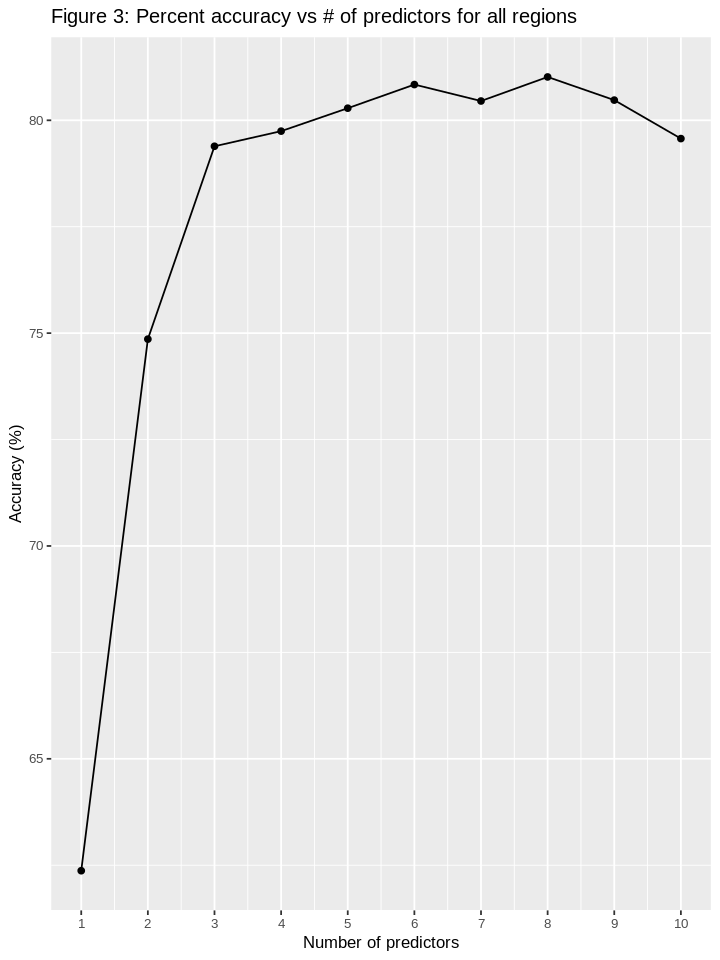

In [15]:
plot_accuracy(all_accuracy, "all regions","3")

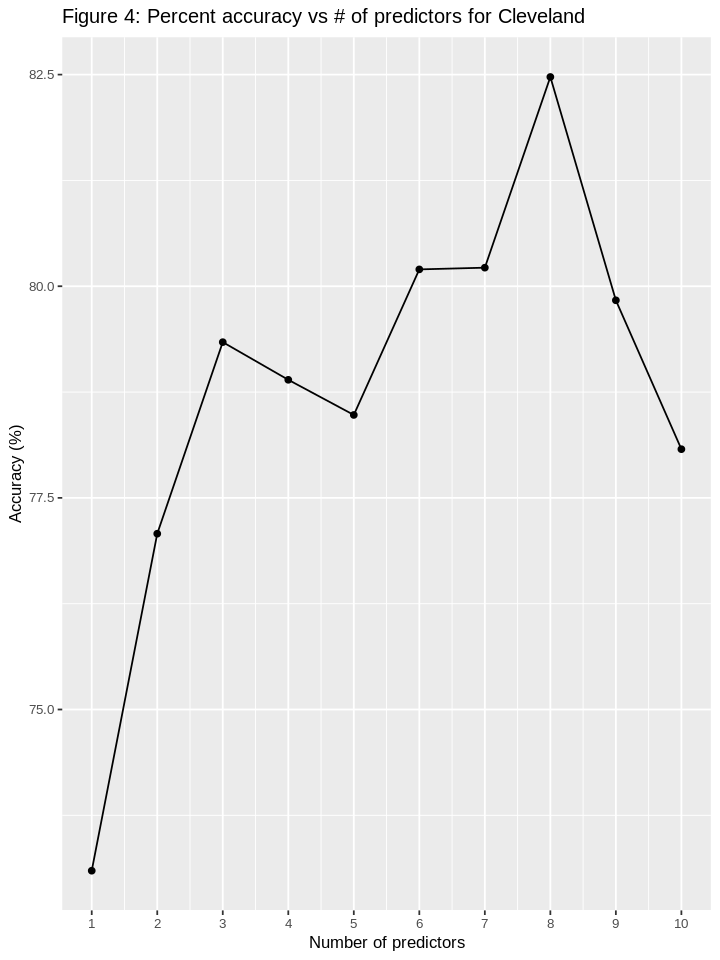

In [16]:
plot_accuracy(cleveland_accuracy, "Cleveland","4")

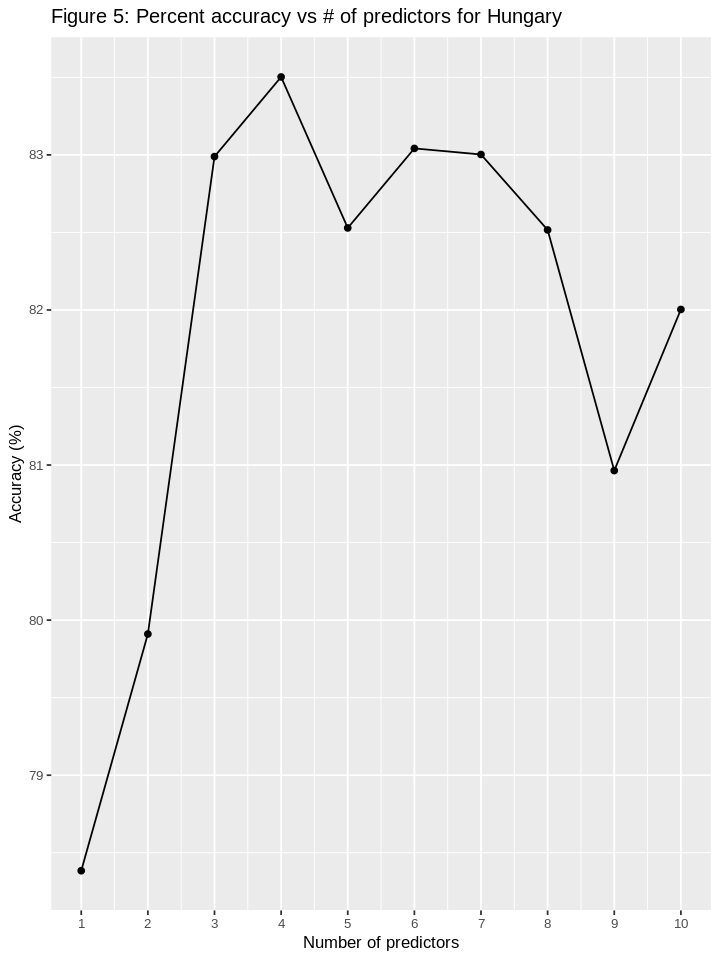

In [17]:
plot_accuracy(hungarian_accuracy, "Hungary","5")

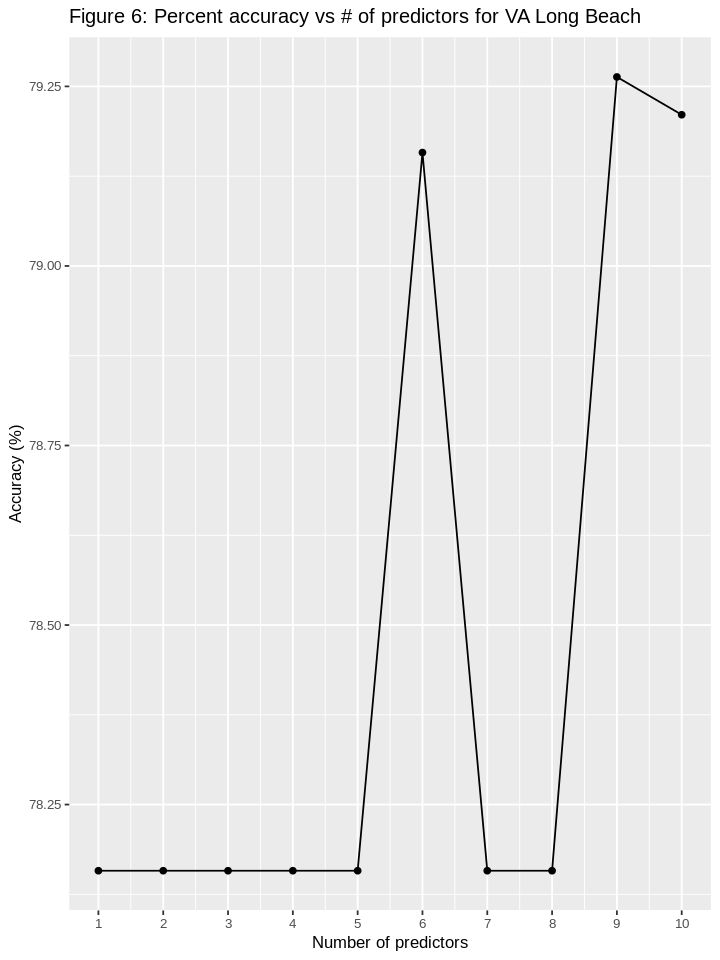

In [18]:
plot_accuracy(va_accuracy, "VA Long Beach","6")

Do note that while the textbook says to pick the "elbow" of the graph, we let our code automatically pick the model with the highest accuracy, out of concern that our relative inexperience will lead to us picking a poor elbow and compromising the accuracy of the model.

### Building the model and estimating its accuracy against the testing data
We write a function that fits a KNN "classification model using the best value of "k" (found during forward selection) and then estimates the accuracy with the testing set. The function returns the model's accuracy, its best value of K, and a confusion matrix for the produced model. The confusion matrices will be invaluable for getting a sense of how accurate this model is, as it cannot be easily graphed given its high dimensionality.

In [19]:
model_and_fit <- function(accuracy_df, train_df, test_df, region=""){
    # get predictors with max accuracy
    best_model <- accuracy_df |> slice_max(percent_accuracy, n = 1) 
    best_predictors <- best_model |> pull(model_string)
    best_k <- best_model |> pull(k)
    
        df_recipe <- recipe(as.formula(best_predictors), data = train_df) |> 
            step_scale(all_predictors()) |> 
            step_center(all_predictors())
    
    print(paste("The best value of K for", region, "is", best_k))
    
    df_spec_k <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |> set_engine("kknn") |> set_mode("classification")
    
    df_fit <- workflow() |>
        add_recipe(df_recipe) |>
        add_model(df_spec_k) |>
        fit(data = train_df)

    df_summary <- df_fit |>
        predict(test_df) |>
        bind_cols(test_df) |>
        metrics(truth = num, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.estimate) |>
        rename(accuracy = .estimate) |>
        pull()

    df_conf_mat <- df_fit |>  predict(test_df) |>
                              bind_cols(test_df) |>
                              conf_mat(truth = num, estimate = .pred_class)
    return(c(df_summary,best_k,df_conf_mat)) # return the tuple so that I can access best_k in code later
    }

# model_and_fit(switzerland_accuracy,switzerland_train,switzerland_test, "Switzerland")[1] # Switzerland explodes for some reason, probably due to lack of data causing unexpected inputs.




#### Calculating accuracy using test dataset: All

In the cells below we call the function we wrote to estimate the accuracy of the model using the testing set. The combined dataset ends up having the best accuracy, of around 82%.

In [20]:
all_mod <- model_and_fit(all_accuracy,all_train,all_test, "all regions combined")
print("Table 8: Accuracy of the best model for all regions combined") # These steps could have been added to the function, but in this position they help serve as titles too.
all_mod[1]


[1] "The best value of K for all regions combined is 13"
[1] "Table 8: Accuracy of the best model for all regions combined"


[[1]]
[1] 0.7903226

#### Calculating accuracy using test dataset: Cleveland

In the cell below we calculate the accuracy of the best model we can make using the data specifically from Cleveland.

In [21]:
cl_mod <- model_and_fit(cleveland_accuracy,cleveland_train,cleveland_test, "Cleveland")
print("Table 10: Accuracy of the best model for Cleveland")
cl_mod[1]


[1] "The best value of K for Cleveland is 12"
[1] "Table 10: Accuracy of the best model for Cleveland"


[[1]]
[1] 0.7894737

#### Calculating accuracy using test dataset: Hungary

In the cell below we calculate the accuracy of the best model we can make using the data specifically from Hungary.

In [22]:
hu_mod <- model_and_fit(hungarian_accuracy,hungarian_train,hungarian_test, "Hungary")
print("Table 12: Accuracy of the best model for Hungary")
hu_mod[1]


[1] "The best value of K for Hungary is 15"
[1] "Table 12: Accuracy of the best model for Hungary"


[[1]]
[1] 0.8030303

#### Calculating accuracy using test dataset: VA Long Beach

In the cell below we calculate the accuracy of the best model we can make using the data specifically from VA Long Beach.

In [23]:
va_mod <- model_and_fit(va_accuracy,va_train,va_test, "VA Long Beach") 
print("Table 14: Accuracy of the best model for VA Long Beach")
va_mod[1]                                                             


[1] "The best value of K for VA Long Beach is 5"
[1] "Table 14: Accuracy of the best model for VA Long Beach"


[[1]]
[1] 0.7575758

## Visualization of the analysis
In this section we use visualization to provide a more concrete interpretation of the results of our analysis. Unfortunately, because we used more than two predictors for each of our models, they are not easily graphed. 

This being the case, the most revealing visualization we can produce is the confusion matrix for each model we generated. The confusion matrices are shown below.



In [24]:
print("Table 9: Confusion Matrix for all regions combined")
all_mod[3]

[1] "Table 9: Confusion Matrix for all regions combined"


$table
          Truth
Prediction false true
     false    75   24
     true     15   72


In [25]:
print("Table 13: Confusion Matrix for Hungary")
hu_mod[3]

[1] "Table 13: Confusion Matrix for Hungary"


$table
          Truth
Prediction false true
     false    38   10
     true      3   15


In [26]:
print("Table 11: Confusion Matrix for Cleveland")
cl_mod[3]

[1] "Table 11: Confusion Matrix for Cleveland"


$table
          Truth
Prediction false true
     false    38   13
     true      3   22


In [27]:
print("Table 15: Confusion Matrix for VA Long Beach")
va_mod[3]

[1] "Table 15: Confusion Matrix for VA Long Beach"


$table
          Truth
Prediction false true
     false     1    1
     true      7   24


As a secondary visualization of the analysis, we will make a simplified version of our model that uses only two parameters so that we can graph it and observe its predictions. We use the Cleveland dataset, as it is the largest of the regional datasets. We will use the predictors of chest pain type (cp) and maximum heart rate achieved (thalach), as those were the two predictors most consistent with the majority of the data sets.  

### Part 1: Find Best K for Simplified Model
In the following cell, we identify the best value of k for our simplified, two-parameter KNN model.

In [28]:
# Part 1: Best K for 2 predictors
# (Since we're unable to visualize more than 3 dimensions, we must pick only 2 predictors: I will select cp and thalach,
# which together had pretty decent accuracy results for most of the regions)

cleveland_recipe <- recipe(num ~ cp + thalach, data = cleveland_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors())
 
cl_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> set_engine("kknn") |> set_mode("classification")

cl_fold <- vfold_cv(cleveland_train, v = 10, strata = num)

cl_k_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(cl_spec_tune) |>
    tune_grid(resamples = cl_fold, grid = 10) |>
    collect_metrics()

cl_best_k <- cl_k_fit |> slice_max(mean, n = 1) |> select(neighbors) |> pull()



# Interesting idea: plot the number of datapoints in a region vs the best value of K. This can be accomplished by counting the rows of each dataframe and binding these summarized tibbles.
# Make the model_and_fit function return a tuple with the accuracy value and the best value of K so that I can pull those and bind them. Or just read the values off the output.

### Part 2: Fit

In the next cell, we use the calculated best value of K in a new model that is fit on the training data. Here we are using the Cleveland model as it had the highest accuracy.

In [29]:
# Part 2: Fit
# We're viewing cleveland because it's the most accurate. (we've also then validated the choice of past ML researchers, who used the cleveland set exclusively as well)

cleveland_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = cl_best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

cleveland_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(cleveland_spec) |>
    fit(data = cleveland_train)


### Part 3: Predict

In the following cell, we create a grid of artificial values that will be used in visualizing where a point has to fall to be classified as having heart disease or not. We predict the num variable of each of these artificial values for this same purpose. This cell uses a lot of code adapted from the textbook.

In [30]:
# Part 3: Predict
# The following code was adapted for this project from Chapter 6 of "Data Science: A First Introduction" by Tiffany Timbers, Trevor Campbell, and Melissa Lee.

thal_grid <- seq(min(cleveland_train$thalach),
                 max(cleveland_train$thalach),
                 length.out = 100) # sets the desired length of the sequence
cp_grid <- seq(min(cleveland_train$cp),
                 max(cleveland_train$cp),
                 length.out = 100) # sets the desired length of the sequence
combined_grid <- as_tibble(expand.grid(thalach = thal_grid, cp = cp_grid))

predicted_grid <- predict(cleveland_fit, combined_grid)

prediction_table <- bind_cols(predicted_grid,combined_grid) |> rename(num = .pred_class)


### Part 4: Graph
In the next cell, we plot the whole Cleveland dataset with the chest pain variable on the x-axis and the maximum heart rate variable on the y-axis of a scatterplot. The predicted grid of artificial values is plotted as well, with a large size and low alpha, as a method of visualizing which areas lead to which specific classifications. The model shows that, for patients tested in a hospital, no chest pain strongly predicts no heart disease. To better visualize the relation of heart disease and thalach (maximum heart rate achieved), plot a histogram to visualize the ratio between patients with and without heart disease. We can see that a higher maximum heart rate tends to have a higher ratio of patients with heart disease.

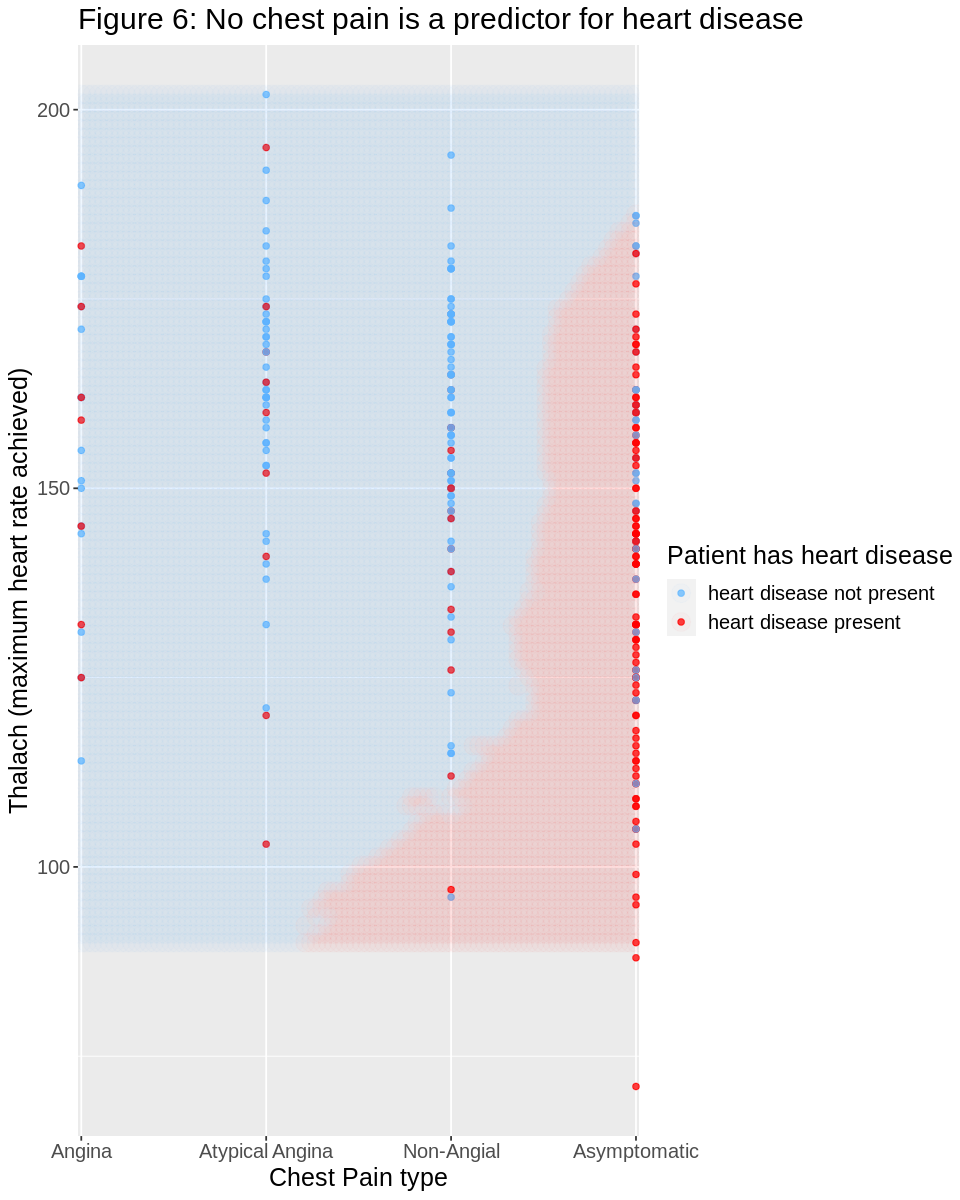

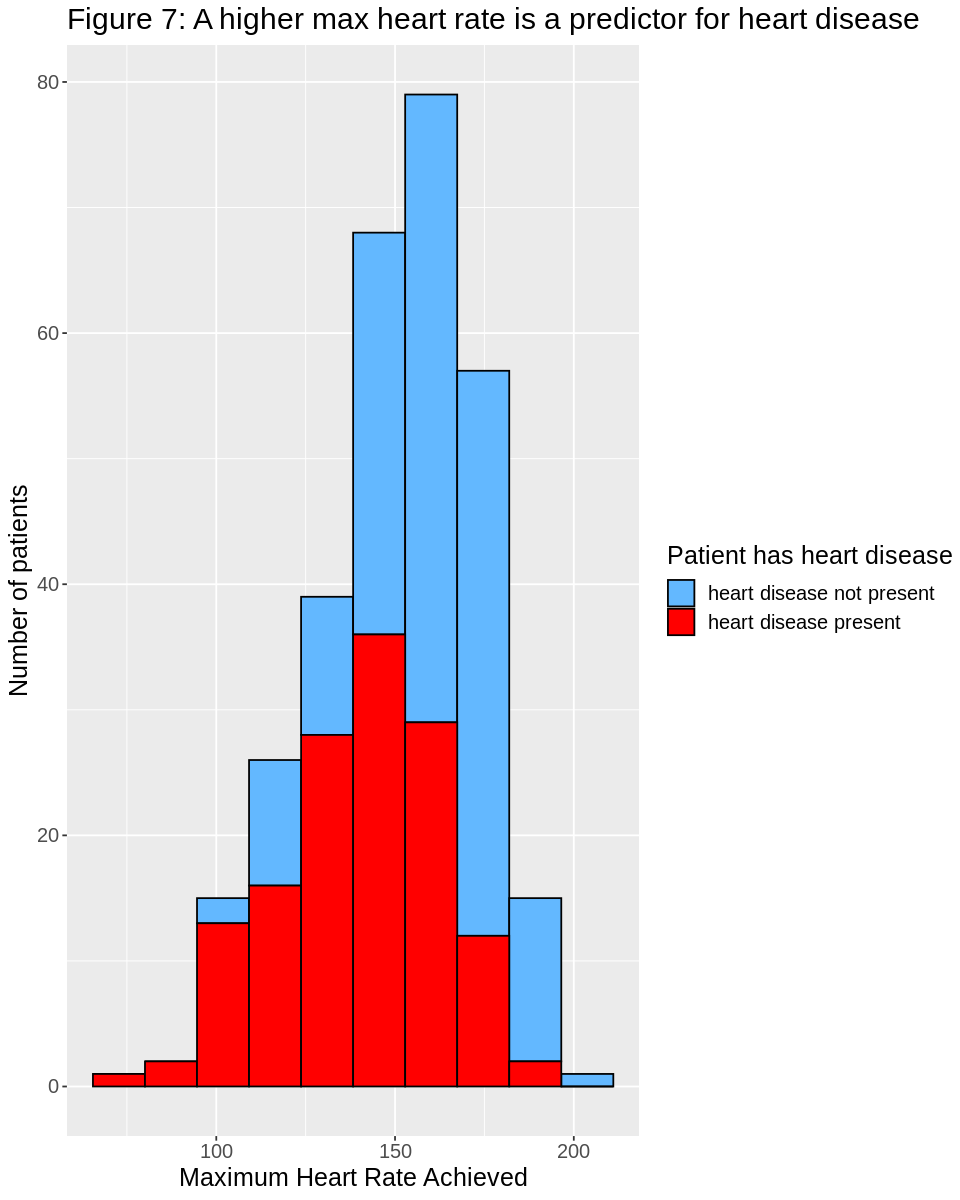

In [31]:
# Set graph dimensions
options(repr.plot.width=8, repr.plot.height=10)

# Part 4: Graph
ggplot() +
    geom_point(data = cleveland_data,
               mapping = aes(x = factor(cp), y = thalach, color = num), alpha = 0.75) +
    geom_point(data = prediction_table,
               mapping = aes(x = factor(cp), y = thalach, color = num), alpha = 0.02, size = 5) +
    labs(color = "Patient has heart disease",
         y = "Thalach (maximum heart rate achieved)",
         x = "Chest Pain type",
         title ="Figure 6: No chest pain is a predictor for heart disease") +
    scale_color_manual(labels = c("true"="heart disease present","false"="heart disease not present"),
                       values = c("steelblue1", "red1")) +
    scale_x_discrete(breaks=c("1","2","3","4"),
        labels=c("Angina", "Atypical Angina", "Non-Angial", "Asymptomatic"))+
    theme(text = element_text(size = 15))
    
    
ggplot(cleveland_data, aes(x=thalach, fill = num)) +
    geom_histogram(bins = 10,position="stack",color="black") +
    labs(fill = "Patient has heart disease",
         y = "Number of patients",
         x = "Maximum Heart Rate Achieved",
         title ="Figure 7: A higher max heart rate is a predictor for heart disease") +
    scale_fill_manual(labels = c("true"="heart disease present", "false"="heart disease not present"),
                       values = c("steelblue1", "red1")) +
    theme(text = element_text(size = 15))


## Discussion

Our analysis created a model that can predict presence of heart disease with an accuracy of ~82%. We conclude that it is possible to predict whether a patient has heart disease based on a set of medical characteristics. This model lacks perfection, but can assist a doctor's diagnosis. For the dataset that combined all regions, our optimal model found the following essential properties for predicting heart disease, in order of top priority:

1. Maximum Heart Rate achieved
2. Chest Pain Type
3. Exercise Induced Angina
4. ST depression Induced by Exercise
5. Sex
6. Resting ECG
7. Serum Cholesterol

It is interesting that while the models for the individual regions usually had most of these predictors, they were never all there, and never in the same order as above. For our primary visualization, we showed the accuracy of our data set with a confusion matrix, due to the high dimensionality of our model. With our secondary visualization, we chose the two most frequent and dominant predictors (chest pain and maximum heart rate achieved) to produce a graph that shows their correlation with heart disease. As seen in Figure 6, patients who were asymptomatic in terms of chest pain were very likely to have no heart disease. This was a fact we fortunately stumbled upon in our pre-analysis visualization, but now know for certain is true. Furthermore, we plotted a histogram to see the relation between heart disease and the maximum heart rate achieved. While the heart rates of patients are somewhat in a normal distribution, the ratio between patients with heart disease and those without heart disease shifts towards heart disease as the maximum heart rate increases. Both these visualizations validate our model's predictors, as the correlation between them and heart disease is observable.

### Is this what you expected to find?

Thanks to our pre-data analysis, we guessed that chest pain would have some correlation with heart disease, otherwiset we had a vague idea about what we would find. Our research to gain more domain knowledge found that nearly all the predictors we chose for the model had one more article indicating a relationship with heart disease. Thus, we weren't able to predict which of the variables would largely impact  our model, other than chest pain. Nonetheless, variables related to heart rate and chest pain, such as the maximum heart rate achieved and exercise induced angina, were found as the siginificant predictors. 

### What impact could such findings have?

These findings assist hospitals in accurately predicting if an individual has a heart disease by attempting to classify it using our dataset. With an accuracy of ~82%, diagnosticians could reduce their workload by using this model to rule out "easier" diagnoses. This model could still be improved. In addition, our model found that the best predictors depend on information related to heart rate and chest pain. These findings prove useful to doctors, as they could focus on tests related to these metrics when working with heart disease.

### What future questions could this lead to?

Regarding our secondary question, we found that different predictors were more significant than others in differing regions. One would expect something as common as heart disease to have common causes. We ask: why do different regions have different variables for predicting heart disease? For example, while most regions have maximum heart rate as a significant predictor that was added early onto the model, the Hungary data set only added it to the end. Another question that this report leads to was why each predictor is related to heart disease? Sex appears to have somewhat of an impact on predicting heart disease, which is surprising and could be used as the basis for further studies of its relation to heart disease. In a more general sense, this report poses the question if this type of model can be formed for all types of diseases.

## References

Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). UCI Machine Learning Repository [ https://archive.ics.uci.edu/ml/datasets/Heart+Disease ]. Irvine, CA: University of California, School of Information and Computer Science

Ritchie, H., Spooner, F., &amp; Roser, M. (2018, February 14). Causes of death. Our World in Data. Retrieved December 3, 2022, from https://ourworldindata.org/causes-of-death 

Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., Karia, K., & Panguluri, S. K. (2019). Cardiovascular Risks Associated with Gender and Aging. Journal of cardiovascular development and disease, 6(2), 19. https://doi.org/10.3390/jcdd6020019

Rawat, S. (2021, June 28). Heart disease prediction. Medium. Retrieved December 3, 2022, from https://towardsdatascience.com/heart-disease-prediction-73468d630cfc 

NHS. (n.d., 2020). Causes - Coronary heart disease. NHS choices. Retrieved December 3, 2022, from https://www.nhs.uk/conditions/coronary-heart-disease/causes/ 

Kaolawanich, Y., & Boonyasirinant, T. (2020). Incremental prognostic value of aortic stiffness in addition to myocardial ischemia by cardiac magnetic resonance imaging. BMC cardiovascular disorders, 20(1), 287. https://doi.org/10.1186/s12872-020-01550-w

Perret-Guillaume, C., Joly, L., & Benetos, A. (2009). Heart rate as a risk factor for cardiovascular disease. Progress in cardiovascular diseases, 52(1), 6–10. https://doi.org/10.1016/j.pcad.2009.05.003

Heran, B. S., Chen, J. M., Ebrahim, S., Moxham, T., Oldridge, N., Rees, K., Thompson, D. R., & Taylor, R. S. (2011). Exercise-based cardiac rehabilitation for coronary heart disease. The Cochrane database of systematic reviews, (7), CD001800. https://doi.org/10.1002/14651858.CD001800.pub2

Timbers, T., Campbell, T., &amp; Lee, M. (2022). Data Science a first introduction. CRC Press, Taylor &amp; Francis Group. 

Watanabe, T., Akutsu, Y., Yamanaka, H., Michihata, T., Okazaki, O., Katagiri, T., & Harumi, K. (2000). Exercise-induced ST-segment depression: imbalance between myocardial oxygen demand and myocardial blood flow. Acta cardiologica, 55(1), 25–31. https://doi.org/10.2143/AC.55.1.2005714

Frieling, T. (2018). Non-cardiac chest pain. Visceral Medicine, 34(2), 92–96. https://doi.org/10.1159/000486440 